In [1]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,DetCurveDisplay,PrecisionRecallDisplay,RocCurveDisplay,classification_report,r2_score
from sklearn.model_selection import GridSearchCV,KFold,cross_validate,train_test_split
from df_after_transform import df_after_transform
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
set_config(display="diagram")

In [2]:
ceo_df = pd.read_csv('./input_data_clean/CEO_DF.csv')
bod_df = pd.read_csv('./input_data_clean/BOD_DF.csv')
firms_df = pd.read_csv('./input_data_clean/FIRMS.csv')

In [3]:
tiny_ceo_df = ceo_df[ceo_df['size_category'] == 'Tiny']
medium_ceo_df = ceo_df[ceo_df['size_category'] == 'Medium']
big_ceo_df = ceo_df[ceo_df['size_category'] == 'Big']
huge_ceo_df = ceo_df[ceo_df['size_category'] == 'Huge']

tiny_bod_df = bod_df[bod_df['size_category'] == 'Tiny']
medium_bod_df = bod_df[bod_df['size_category'] == 'Medium']
big_bod_df = bod_df[bod_df['size_category'] == 'Big']
huge_bod_df = bod_df[bod_df['size_category'] == 'Huge']

list_ceo_df = [tiny_ceo_df, medium_ceo_df, big_ceo_df, huge_ceo_df]
list_bod_df = [tiny_bod_df, medium_bod_df, big_bod_df, huge_bod_df]

In [4]:
huge_bod_df.describe()

,Unnamed: 0.1,Unnamed: 0,gvkey,total_sec,othcomp,noneq_incent,cash_fees,stock_awards,option_awards,year,...,total_option_awards,mkvalt,liquidity,net_income,num_employees,market_value,debt_to_equity,assets_in_place,capex_by_assets,return_on_equity
count,608.000000,608.000000,608.000000,6.080000e+02,608.000000,608.0,608.000000,6.080000e+02,608.000000,608.000000,...,608.000000,6.080000e+02,354.000000,288.000000,592.000000,517.000000,608.000000,384.000000,288.000000,288.000000
mean,3041.952303,3041.952303,33366.315789,3.475338e+03,17.243888,0.0,117.566641,3.333664e+03,6.106836,2015.884868,...,364.670497,2.297246e+05,0.156435,9387.902597,206.824807,186656.915049,5.207563,0.374523,0.041719,0.092266
std,2523.684669,2523.684669,59000.280318,7.815860e+04,40.561433,0.0,82.094512,7.816430e+04,38.509632,2.323840,...,852.979081,1.279717e+05,0.169005,8708.132569,272.479593,101425.213942,13.663115,0.343122,0.029739,0.054700
min,16.000000,16.000000,1078.000000,0.000000e+00,-41.092000,0.0,0.000000,0.000000e+00,0.000000,2011.000000,...,0.000000,1.000702e+05,-0.125177,-6127.000000,3.200000,15787.310000,-69.004392,0.033726,0.003735,-0.012436
25%,935.750000,935.750000,3243.000000,2.725930e+02,0.000000,0.0,83.750000,1.500000e+02,0.000000,2014.000000,...,0.000000,1.480922e+05,0.023593,4147.973000,76.700000,115158.024000,1.179252,0.111272,0.018871,0.053675
50%,2440.500000,2440.500000,7647.000000,3.221775e+02,1.334500,0.0,113.750000,1.800020e+02,0.000000,2016.000000,...,0.000000,1.979348e+05,0.113853,7022.500000,209.376000,167256.345900,2.296853,0.272054,0.033724,0.085322
75%,3586.250000,3586.250000,11259.000000,3.586325e+02,15.000000,0.0,145.000000,2.000000e+02,0.000000,2018.000000,...,0.000000,2.834385e+05,0.278133,11945.500000,264.200000,232471.495600,8.251388,0.490235,0.058842,0.127280
max,8541.000000,8541.000000,180711.000000,1.927511e+06,261.469000,0.0,793.087000,1.927511e+06,377.861000,2019.000000,...,4512.576000,1.073391e+06,0.720754,53394.000000,2300.000000,790050.098100,258.932394,1.374192,0.151352,0.271061


In [5]:
df = huge_bod_df
df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'gvkey', 'total_sec'], axis=1, inplace=True)

# Create boolean masks for the train and holdout periods
train_mask = df.loc[(df['year'] >= 2010) & (df['year'] <= 2016)]
holdout_mask = df.loc[(df['year'] >= 2017) & (df['year'] <= 2019)]

y = np.log(train_mask.total_director_comp)
X = train_mask.drop('total_director_comp', axis=1)

VarY = holdout_mask[['signature_index', 'total_director_comp']]
VarY.to_csv('./Saved/huge_bod_df.csv', index=False)

holdout_set = holdout_mask


holdout_X = holdout_set.drop(['signature_index', 'total_director_comp'], axis=1)

rng = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

missing_cols = set(X_train.columns) - set(holdout_X.columns)
for col in missing_cols:
    holdout_X[col] = 0
holdout_X = holdout_X[X_train.columns]

/var/folders/29/vl12lkgs28xgjpc6t0_jg9040000gn/T/ipykernel_2723/3875965264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'gvkey', 'total_sec'], axis=1, inplace=True)
/Users/annaharv46/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
cv = KFold(10)

In [7]:
numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    remainder="drop",
)
# pipe = Pipeline([('columntransformer',preproc_pipe),
#                  ('feature_select',SelectKBest()), 
#                  ('clf', Ridge())
#                 ])

ridge_pipe = Pipeline([
    ('preprocessor', preproc_pipe),
    ('ridge', Ridge())
])

In [8]:
y_train = y_train.replace(-np.inf, 0)

In [9]:
y_train.describe()

count    247.000000
mean       7.791080
std        1.413606
min        0.000000
25%        7.887959
50%        8.161144
75%        8.368576
max        8.836641
Name: total_director_comp, dtype: float64

In [10]:
alphas = list(np.linspace(0, 7000, 25))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

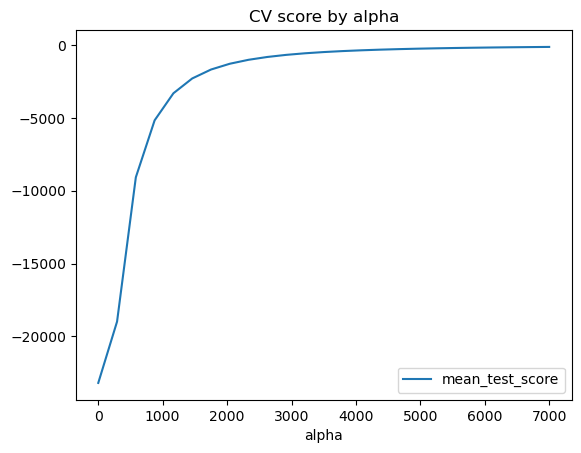

In [11]:
results_df = pd.DataFrame(results.cv_results_).set_index('params')
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha', y='mean_test_score', kind='line', title='CV score by alpha')

<AxesSubplot:title={'center':'CV score by alpha'}, xlabel='alpha'>

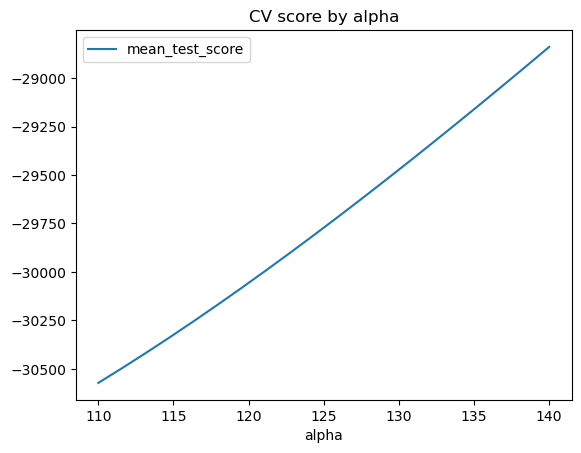

In [12]:
alphas = list(np.linspace(110, 140,20))
parameters = {'ridge__alpha': alphas}

grid_search = GridSearchCV(estimator=ridge_pipe, 
                           param_grid=parameters,
                           cv=cv,
                           scoring='r2')

results = grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(results.cv_results_).set_index('params')
# extract alpha from the params variable
results_df['alpha'] = [c['ridge__alpha'] for c in results_df.index]
results_df = results_df.sort_values('alpha')
results_df.plot(x='alpha',y='mean_test_score',kind='line',
                title='CV score by alpha')

In [13]:
best_alpha = results_df.query('rank_test_score == 1')['param_ridge__alpha'][0]
print('The optimal ridge alpha is: %.5f' % best_alpha)

The optimal ridge alpha is: 140.00000


In [14]:
print('The mean test score for this alpha is: %.5f' % results_df.query('rank_test_score == 1')['mean_test_score'][0])

The mean test score for this alpha is: -28839.42227


In [15]:
cv = KFold(10)

numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipe = make_pipeline(OneHotEncoder())

preproc_pipe = make_column_transformer(
    (numer_pipe, make_column_selector(dtype_include=np.number)),
    remainder="drop",
)


In [16]:
import warnings

# ignore the specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.feature_selection import SelectPercentile, f_regression

pipe = Pipeline([('columntransformer',preproc_pipe),
                 ('feature_select',SelectPercentile(score_func=f_regression)), 
                 ('clf', Ridge())
                ])

param_grid = {
    # 'feature_select__percentile': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    # 'feature_select__percentile': [90, 91, 92, 93, 94, 95, 96, 97],
    # 'feature_select__percentile': [83, 84, 85, 86, 87, 88, 89, 90],
    'feature_select__percentile': [57, 58, 59 ,60, 61, 62, 63, 64],

    # 'feature_select__percentile': [18, 19, 20, 21, 22, 23, 24, 25],

    # 'clf__alpha': [18, 19, 20, 21, 22, 23, 24, 25], 
    # 'clf__alpha': [0.5, 0.75, 0.9, 1.23, 1.45, 1.57895, 1.7, 1.8],
    # 'clf__alpha': [200, 205, 208, 210, 213, 215, 220, 225],
    # 'clf__alpha': [186, 188, 190, 192, 194, 196], 
    'clf__alpha': [105, 107, 109, 111, 112, 113, 114, 115], 
    # 'clf__alpha': [14.5,15,15.5,16, 16.5, 17], 
    # 'clf__alpha': [47, 48, 49, 50, 51, 52, 53, 54], 

# 

}

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid,
                           cv=cv,
                           scoring='r2',
                           error_score='raise')

results = grid_search.fit(X_train, y_train)


In [17]:
results_data = pd.DataFrame(results.cv_results_)
results_data = results_data[['params','mean_test_score','std_test_score']]
results_data['alpha'] = results_data['params'].apply(lambda x: x.get('clf__alpha'))
results_data['k'] = results_data['params'].apply(lambda x: x.get('feature_select__percentile'))
results_data

,params,mean_test_score,std_test_score,alpha,k
0,"{'clf__alpha': 105, 'feature_select__percentil...",-28805.110734,86416.544470,105,57
1,"{'clf__alpha': 105, 'feature_select__percentil...",-30061.002023,90184.219786,105,58
2,"{'clf__alpha': 105, 'feature_select__percentil...",-30061.002023,90184.219786,105,59
3,"{'clf__alpha': 105, 'feature_select__percentil...",-30061.002023,90184.219786,105,60
4,"{'clf__alpha': 105, 'feature_select__percentil...",-30061.002023,90184.219786,105,61
...,...,...,...,...,...
59,"{'clf__alpha': 115, 'feature_select__percentil...",-29716.486650,89150.662062,115,60
60,"{'clf__alpha': 115, 'feature_select__percentil...",-29716.486650,89150.662062,115,61
61,"{'clf__alpha': 115, 'feature_select__percentil...",-29716.486650,89150.662062,115,62
62,"{'clf__alpha': 115, 'feature_select__percentil...",-29716.486650,89150.662062,115,63


Text(56    85516.067494
Name: std_test_score, dtype: float64, 56   -28504.955183
Name: mean_test_score, dtype: float64, 'Best params: k=57, alpha=115     ')

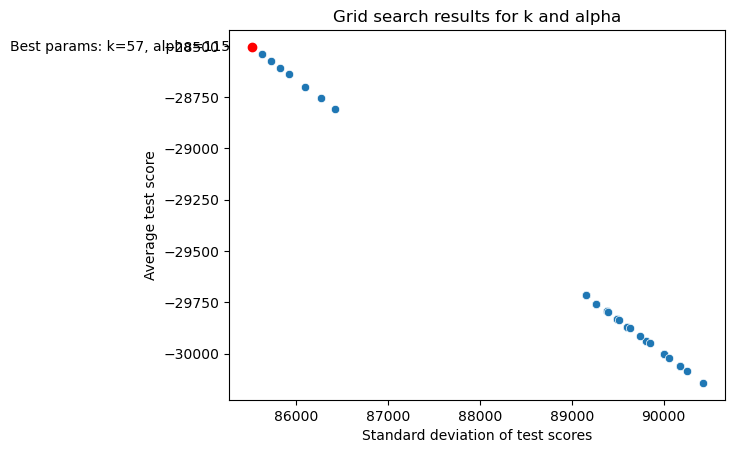

In [18]:
sns.scatterplot(data=results_data, x='std_test_score', y='mean_test_score')
plt.xlabel('Standard deviation of test scores')
plt.ylabel('Average test score')
plt.title('Grid search results for k and alpha')

best_params = grid_search.best_params_
best_k = best_params['feature_select__percentile']
best_alpha = best_params['clf__alpha']
plt.scatter(x=results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'std_test_score'], 
            y=results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'mean_test_score'], color='red')
plt.text(results_data.loc[(results_data['k'] == best_k) 
                                       & (results_data['alpha'] == best_alpha),
                                       'std_test_score'],
         results_data.loc[(results_data['k'] == best_k) 
                                & (results_data['alpha'] == best_alpha),
                                'mean_test_score'], 
         f"Best params: k={best_k}, alpha={best_alpha}     ", ha='right', va='center')

In [19]:
opt_pipe = make_pipeline(preproc_pipe, SelectPercentile(score_func=f_regression, percentile=best_k), Ridge(alpha=best_alpha))
opt_pipe.fit(X_train, y_train)

y_holdout_pred = opt_pipe.predict(holdout_X)

# create a dataframe with the parcel ID and the predicted values
df_out = pd.DataFrame({'signature_index': VarY['signature_index'], 'prediction': np.exp(y_holdout_pred) })
# merged_df = pd.merge(VarY, df_out, on='signature_index')

In [21]:
# df_out.to_csv('./Saved/pred_big_bod_df.csv', index=False)